C:\Users\hoang\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\hoang\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


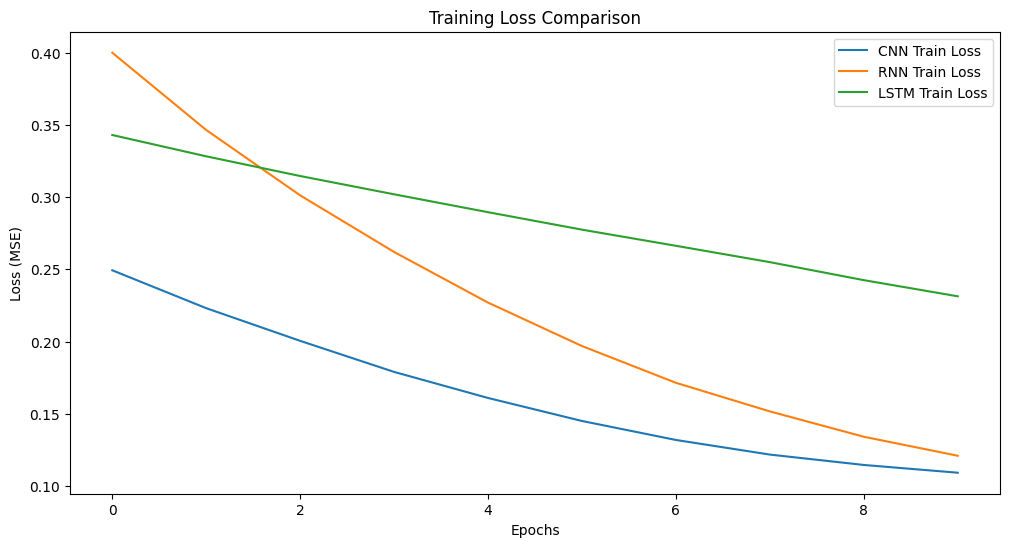

In [4]:
import tkinter as tk
from tkinter import messagebox
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, SimpleRNN, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 1. Tạo dataset với thông tin bất động sản cơ bản
def create_dataset():
    data = {
        "location": ["Hanoi"] * 50 + ["Ha Dong"] * 50,
        "size": np.random.randint(30, 150, 100),
        "price": np.random.randint(1_000, 10_000, 100)
    }
    df = pd.DataFrame(data)
    df["location"] = df["location"].apply(lambda x: 1 if x == "Hanoi" else 0)
    return df

# 2. Chuẩn hóa và tiền xử lý dữ liệu
df = create_dataset()
X = df[["location", "size"]].values
y = df["price"].values.reshape(-1, 1)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)
X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# 3. Khởi tạo các mô hình CNN, RNN, và LSTM và huấn luyện với lịch sử loss
def build_models():
    models = {
        "CNN": Sequential([
            Conv1D(32, 2, activation="relu", input_shape=(2, 1)),
            Flatten(),
            Dense(1)
        ]),
        "RNN": Sequential([
            SimpleRNN(32, activation="relu", input_shape=(2, 1)),
            Dense(1)
        ]),
        "LSTM": Sequential([
            LSTM(32, activation="relu", input_shape=(2, 1)),
            Dense(1)
        ])
    }
    history = {}
    for name, model in models.items():
        model.compile(optimizer="adam", loss="mse")
        hist = model.fit(X_scaled, y_scaled, epochs=10, verbose=0)
        history[name] = hist.history["loss"]
    return models, history

models, history = build_models()

# 4. Hàm dự đoán giá bất động sản
def predict_price(location, size):
    input_data = scaler_X.transform([[location, size]])
    input_data = input_data.reshape(1, 2, 1)

    predictions = {}
    for name, model in models.items():
        pred = model.predict(input_data)
        predictions[name] = scaler_y.inverse_transform(pred)[0, 0]
    return predictions

# 5. Hàm tạo biểu đồ
def plot_comparison(history):
    plt.figure(figsize=(12, 6))
    for model_name, loss in history.items():
        plt.plot(loss, label=f"{model_name} Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.title("Training Loss Comparison")
    plt.legend()
    plt.show()

# 6. Giao diện người dùng với Tkinter
root = tk.Tk()
root.title("Dự đoán giá bất động sản")

tk.Label(root, text="Vị trí (0: Hà Đông, 1: Hà Nội):").grid(row=0, column=0, padx=10, pady=5)
location_entry = tk.Entry(root)
location_entry.grid(row=0, column=1, padx=10, pady=5)

tk.Label(root, text="Diện tích (m2):").grid(row=1, column=0, padx=10, pady=5)
size_entry = tk.Entry(root)
size_entry.grid(row=1, column=1, padx=10, pady=5)

# Hàm xử lý sự kiện khi nhấn nút Dự đoán
def on_predict():
    try:
        location = int(location_entry.get())
        size = float(size_entry.get())
        if location not in [0, 1]:
            messagebox.showerror("Lỗi", "Vui lòng nhập 0 cho Hà Đông hoặc 1 cho Hà Nội")
            return
    except ValueError:
        messagebox.showerror("Lỗi", "Vui lòng nhập số hợp lệ cho vị trí và diện tích")
        return

    predictions = predict_price(location, size)
    result_text = "\n".join([f"{name} dự đoán: {price:,.2f} ngàn VNĐ" for name, price in predictions.items()])
    messagebox.showinfo("Kết quả dự đoán", result_text)
    plot_comparison(history)  # Hiển thị biểu đồ so sánh sau khi dự đoán

# Nút dự đoán
predict_button = tk.Button(root, text="Dự đoán giá", command=on_predict)
predict_button.grid(row=2, column=0, columnspan=2, pady=10)

# Chạy ứng dụng
root.mainloop()
